# Grammar Correction using Encoder and Decoder

### Group Members:
1. Rohit Dahale (202201070052)
2. Sakshi Aher (202201040089)
3. Akhilesh Ukey (202201040136)

Dataset Link - https://www.kaggle.com/datasets/satishgunjal/grammar-correction

Reference Paper - Wang, J., Huang, G., & Wang, Y. (2022). An automatic grammar error correction model based on encoder-decoder structure for English texts. EAI Endorsed Transactions on Scalable Information Systems, 10(1), e10.
Link - https://www.researchgate.net/publication/363524576_Automatic_Grammar_Error_Correction_Model_Based_on_Encoder-decoder_Structure_for_English_Texts


In [12]:
!pip install rouge-score --quiet

# Importing Libraries

In [13]:
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

# Dataset Loading and Preprocessing

In [16]:
# ─── Load and Prepare Dataset ───────────────────────────────────
df = pd.read_csv('/content/Grammar_Correction.csv')[['Ungrammatical Statement', 'Standard English']].dropna()
df.columns = ['input_text', 'target_text']
df['input_text'] = df['input_text'].str.lower().str.strip()
df['target_text_with_tags'] = df['target_text'].apply(lambda x: "<start> " + x.lower().strip() + " <end>")

# ─── Split Data ─────────────────────────────────────────────────
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    df['input_text'], df['target_text_with_tags'], test_size=0.1, random_state=42
)
train_targets_plain, test_targets_plain = train_test_split(
    df['target_text'], test_size=0.1, random_state=42
)

df.head(5)

,input_text,target_text,target_text_with_tags
0,the most most powerful superhero is superman.,The most powerful superhero is Superman.,<start> the most powerful superhero is superma...
1,the hotel room is more smaller than i expected.,The hotel room is smaller than I expected.,<start> the hotel room is smaller than i expec...
2,"23. beauty is in the eye of the beholder, but ...",23. Beauty is in the eye of the beholder.,<start> 23. beauty is in the eye of the behold...
3,the new intern is a quick learner and always k...,The new intern is a quick learner and always e...,<start> the new intern is a quick learner and ...
4,"the job requires research skills, good communi...","The job requires research skills, good communi...","<start> the job requires research skills, good..."


# Tokenization

In [17]:
# ─── Tokenization for LSTM Models ───────────────────────────────────────
SRC_VOCAB_SIZE = 10000
TGT_VOCAB_SIZE = 10000

src_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=SRC_VOCAB_SIZE, oov_token="<unk>")
tgt_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TGT_VOCAB_SIZE, filters='', oov_token="<unk>")

src_tokenizer.fit_on_texts(train_inputs)
tgt_tokenizer.fit_on_texts(train_targets)

def encode_pad(texts, tokenizer):
    sequences = tokenizer.texts_to_sequences(texts)
    maxlen = max(len(seq) for seq in sequences)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding='post')
    return padded, maxlen

train_src_seq, src_maxlen = encode_pad(train_inputs, src_tokenizer)
train_tgt_seq, tgt_maxlen = encode_pad(train_targets, tgt_tokenizer)
test_src_seq, _ = encode_pad(test_inputs, src_tokenizer)
test_tgt_seq, _ = encode_pad(test_targets, tgt_tokenizer)

# Model 1 : LSTM Without Attention


Epoch 1/15 • Loss: 2.8472
Epoch 2/15 • Loss: 2.1322
Epoch 3/15 • Loss: 1.6357
Epoch 4/15 • Loss: 1.2218
Epoch 5/15 • Loss: 0.8958
Epoch 6/15 • Loss: 0.6615
Epoch 7/15 • Loss: 0.4911
Epoch 8/15 • Loss: 0.3580
Epoch 9/15 • Loss: 0.2569
Epoch 10/15 • Loss: 0.1802
Epoch 11/15 • Loss: 0.1308
Epoch 12/15 • Loss: 0.0860
Epoch 13/15 • Loss: 0.0588
Epoch 14/15 • Loss: 0.0424
Epoch 15/15 • Loss: 0.0293

Training completed in 122.45 seconds


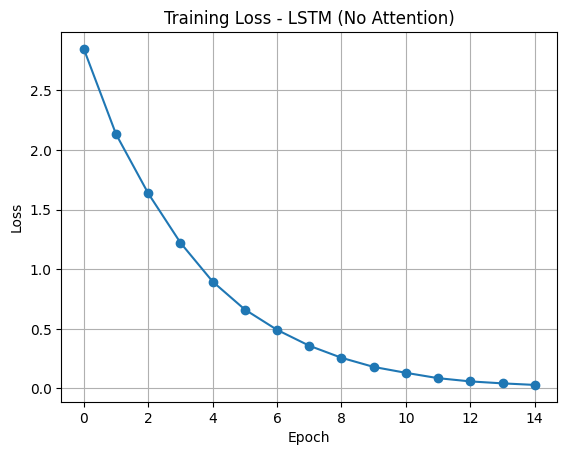


Evaluating on 100 test samples...

BLEU Score     : 0.9225
ROUGE-L F1     : 0.9457
METEOR Score   : 0.9410
Infer Speed    : 0.1337 sec/sample


In [27]:
# ─── Encoder & Decoder (LSTM) ─────────────────────────────────
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, dropout=0.3):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.lstm = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, h, c = self.lstm(x)
        return output, h, c

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, dropout=0.3):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.lstm = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, state):
        x = self.embedding(x)
        x = self.dropout(x)
        output, h, c = self.lstm(x, initial_state=state)
        return self.fc(output), h, c

# ─── Hyperparameters ──────────────────────────────────────────
EMBED_DIM = 256
UNITS = 512
BATCH_SIZE = 32
EPOCHS = 15

encoder = Encoder(SRC_VOCAB_SIZE, EMBED_DIM, UNITS)
decoder = Decoder(TGT_VOCAB_SIZE, EMBED_DIM, UNITS)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

# ─── Dataset ──────────────────────────────────────────────────
train_dataset = tf.data.Dataset.from_tensor_slices((train_src_seq, train_tgt_seq))
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

# ─── Training Step ────────────────────────────────────────────
@tf.function
def train_step(src, tgt):
    loss = 0
    with tf.GradientTape() as tape:
        enc_out, enc_h, enc_c = encoder(src)
        dec_input = tgt[:, :-1]
        real_output = tgt[:, 1:]
        logits, _, _ = decoder(dec_input, state=[enc_h, enc_c])
        mask = tf.cast(tf.math.not_equal(real_output, 0), tf.float32)
        loss = loss_fn(real_output, logits)
        loss = tf.reduce_mean(loss * mask)

    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, vars_)
    optimizer.apply_gradients(zip(grads, vars_))
    return loss

# ─── Training Loop ────────────────────────────────────────────
loss_history = []
train_start = time.time()
for epoch in range(1, EPOCHS+1):
    total_loss = 0
    for batch, (src_b, tgt_b) in enumerate(train_dataset):
        batch_loss = train_step(src_b, tgt_b)
        total_loss += batch_loss
    epoch_loss = total_loss / (batch + 1)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch}/{EPOCHS} • Loss: {epoch_loss:.4f}")
train_time = time.time() - train_start
print(f"\nTraining completed in {train_time:.2f} seconds")

# ─── Plot Loss ────────────────────────────────────────────────
plt.plot(loss_history, marker='o')
plt.title('Training Loss - LSTM (No Attention)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ─── Greedy Inference ─────────────────────────────────────────
def greedy_decode(input_seq, max_len=50):
    enc_out, enc_h, enc_c = encoder(tf.expand_dims(input_seq, 0))
    dec_input = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    result = []
    for _ in range(max_len):
        logits, enc_h, enc_c = decoder(dec_input, state=[enc_h, enc_c])
        pred_token = tf.argmax(logits[0, -1, :]).numpy()
        if pred_token == tgt_tokenizer.word_index.get('<end>'):
            break
        result.append(pred_token)
        dec_input = tf.expand_dims([pred_token], 0)
    return result

# ─── Evaluation ───────────────────────────────────────────────
print("\nEvaluating on 100 test samples...")
bleu_scores, meteor_scores, rouge_l_f1, accuracies = [], [], [], []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4
start_infer = time.time()

for i in range(100):
    src_seq = test_src_seq[i]
    tgt_seq = test_tgt_seq[i]
    pred_seq = greedy_decode(src_seq)
    pred_words = [tgt_tokenizer.index_word.get(idx, '') for idx in pred_seq if idx > 0]
    ref_words = [tgt_tokenizer.index_word.get(idx, '') for idx in tgt_seq if idx > 0 and idx != tgt_tokenizer.word_index.get('<start>') and idx != tgt_tokenizer.word_index.get('<end>')]

    pred_words = [w for w in pred_words if w]
    ref_words = [w for w in ref_words if w]

    bleu = sentence_bleu([ref_words], pred_words, smoothing_function=smoothie)
    meteor = meteor_score([ref_words], pred_words)
    rouge = scorer.score(" ".join(ref_words), " ".join(pred_words))['rougeL'].fmeasure
    accuracy = sum(p == r for p, r in zip(pred_seq, tgt_seq)) / max(len(tgt_seq), 1)

    bleu_scores.append(bleu)
    meteor_scores.append(meteor)
    rouge_l_f1.append(rouge)
    accuracies.append(accuracy)

inference_time = time.time() - start_infer
avg_infer_speed = inference_time / 100

# ─── Results ──────────────────────────────────────────────────
print(f"\nBLEU Score     : {np.mean(bleu_scores):.4f}")
print(f"ROUGE-L F1     : {np.mean(rouge_l_f1):.4f}")
print(f"METEOR Score   : {np.mean(meteor_scores):.4f}")
print(f"Infer Speed    : {avg_infer_speed:.4f} sec/sample")

# Model 2 : LSTM + Bahdanau Attention

Epoch 1 • Loss: 2.9343 • Time: 57.9s
Epoch 2 • Loss: 2.2075 • Time: 43.6s
Epoch 3 • Loss: 1.7261 • Time: 45.2s
Epoch 4 • Loss: 1.3311 • Time: 42.4s
Epoch 5 • Loss: 0.9874 • Time: 42.7s
Epoch 6 • Loss: 0.7100 • Time: 43.9s
Epoch 7 • Loss: 0.5015 • Time: 44.5s
Epoch 8 • Loss: 0.3473 • Time: 42.4s
Epoch 9 • Loss: 0.2356 • Time: 42.0s
Epoch 10 • Loss: 0.1551 • Time: 41.5s
Epoch 11 • Loss: 0.1053 • Time: 41.5s
Epoch 12 • Loss: 0.0684 • Time: 41.4s
Epoch 13 • Loss: 0.0482 • Time: 41.3s
Epoch 14 • Loss: 0.0311 • Time: 41.3s
Epoch 15 • Loss: 0.0277 • Time: 81.9s
Evaluating LSTM with attention...

=== LSTM with Attention Evaluation Results ===
BLEU Score     : 0.8899
ROUGE-L F1     : 0.9207
METEOR Score   : 0.9088
Infer Speed    : 0.1962 sec/sample


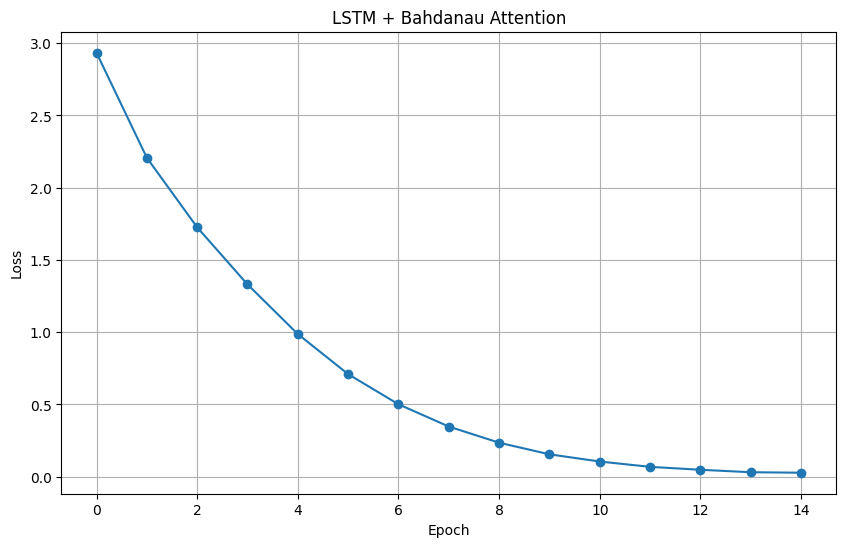

In [22]:
# ─── Bahdanau Attention Layer ─────────────────────────────────────────────
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)

    def call(self, query, values):
        q_time = tf.expand_dims(query, 1)
        score  = self.V(tf.nn.tanh(self.W1(q_time) + self.W2(values)))
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(weights * values, axis=1)
        return context, tf.squeeze(weights, -1)

# ─── Encoder ──────────────────────────────────────────────────────────────
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, enc_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units,
                                          return_sequences=True,
                                          return_state=True)
    def call(self, x):
        x = self.embedding(x)
        x, h, c = self.lstm(x)
        return x, h, c

# ─── Decoder ──────────────────────────────────────────────────────────────
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, dec_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                          return_sequences=True,
                                          return_state=True)
        self.attn = BahdanauAttention(dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_out, state):
        h, c = state
        outputs = []
        for t in range(x.shape[1]):
            xt = self.embedding(x[:, t:t+1])
            context, _ = self.attn(h, enc_out)
            context = tf.expand_dims(context, 1)
            lstm_in = tf.concat([context, xt], axis=-1)
            out, h, c = self.lstm(lstm_in, initial_state=[h, c])
            outputs.append(self.fc(out))
        return tf.concat(outputs, axis=1), h, c

# ─── Prepare Dataset ──────────────────────────────────────────────────────
ATTN_EMBED_DIM = 128
ATTN_UNITS = 256
ATTN_BATCH_SIZE = 16
ATTN_EPOCHS = 15

dataset = tf.data.Dataset.from_tensor_slices((train_src_seq, train_tgt_seq))
dataset = dataset.shuffle(10000).batch(ATTN_BATCH_SIZE, drop_remainder=True)

# ─── Initialize Models & Optimizer ────────────────────────────────────────
attn_encoder = Encoder(SRC_VOCAB_SIZE, ATTN_EMBED_DIM, ATTN_UNITS)
attn_decoder = Decoder(TGT_VOCAB_SIZE, ATTN_EMBED_DIM, ATTN_UNITS)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(src, tgt):
    with tf.GradientTape() as tape:
        enc_out, enc_h, enc_c = attn_encoder(src)
        dec_input = tgt[:, :-1]
        real_output = tgt[:, 1:]
        logits, _, _ = attn_decoder(dec_input, enc_out, state=[enc_h, enc_c])

        # Apply mask for padding
        mask = tf.cast(tf.math.not_equal(real_output, 0), dtype=tf.float32)
        loss = loss_fn(real_output, logits)
        loss = tf.reduce_mean(loss * mask)

    vars_ = attn_encoder.trainable_variables + attn_decoder.trainable_variables
    grads = tape.gradient(loss, vars_)
    optimizer.apply_gradients(zip(grads, vars_))
    return loss

# ─── Training Loop ────────────────────────────────────────────────────────
history_attn = []
start_train_attn = time.time()
for epoch in range(1, ATTN_EPOCHS+1):
    total_loss = 0.0
    start = time.time()
    for batch, (src_b, tgt_b) in enumerate(dataset):
        total_loss += train_step(src_b, tgt_b)
    avg_loss = total_loss / (batch+1)
    history_attn.append(avg_loss)
    print(f"Epoch {epoch} • Loss: {avg_loss:.4f} • Time: {time.time()-start:.1f}s")
train_time_attn = time.time() - start_train_attn

# ─── Evaluation ───────────────────────────────────────────────────────────
print("Evaluating LSTM with attention...")
bleu_scores_attn = []
meteor_scores_attn = []
rouge_l_f1_attn = []
accuracies_attn = []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def decode_sequence(src_seq):
    enc_out, h, c = attn_encoder(tf.expand_dims(src_seq, 0))
    dec_input = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    result = []
    for _ in range(50):
        logits, h, c = attn_decoder(dec_input, enc_out, [h, c])
        token_id = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]
        if token_id == tgt_tokenizer.word_index['<end>']:
            break
        result.append(token_id)
        dec_input = tf.expand_dims([token_id], 0)
    return result

start_infer_attn = time.time()
for i in range(100):  # Evaluate 100 samples
    src = test_src_seq[i]
    tgt = test_tgt_seq[i]

    pred_ids = decode_sequence(src)

    # Filter out padding, start and end tokens
    tgt_ids = [i for i in tgt if i > 0 and
               i != tgt_tokenizer.word_index.get('<start>') and
               i != tgt_tokenizer.word_index.get('<end>')]

    # Convert to words
    pred_words = [tgt_tokenizer.index_word.get(idx, '') for idx in pred_ids]
    tgt_words = [tgt_tokenizer.index_word.get(idx, '') for idx in tgt_ids]

    # Clean out empty strings
    pred_words = [w for w in pred_words if w]
    tgt_words = [w for w in tgt_words if w]

    # Calculate metrics
    bleu_scores_attn.append(sentence_bleu([tgt_words], pred_words, smoothing_function=smoothie))
    meteor_scores_attn.append(meteor_score([tgt_words], pred_words))
    rouge_l_f1_attn.append(scorer.score(' '.join(tgt_words), ' '.join(pred_words))['rougeL'].fmeasure)
    accuracies_attn.append(int(pred_words == tgt_words))

avg_infer_speed_attn = (time.time() - start_infer_attn) / 100

# ─── Plot Loss ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.plot(history_attn, marker='o')
plt.title('LSTM + Bahdanau Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Final Evaluation Results
print("\n=== LSTM with Attention Evaluation Results ===")
print(f"BLEU Score     : {np.mean(bleu_scores_attn):.4f}")
print(f"ROUGE-L F1     : {np.mean(rouge_l_f1_attn):.4f}")
print(f"METEOR Score   : {np.mean(meteor_scores_attn):.4f}")
print(f"Infer Speed    : {avg_infer_speed_attn:.4f} sec/sample")


Setting up T5 Transformer...
Using device: cuda
Epoch 1/3 - Loss: 0.3938 - Time: 103.9s
Epoch 2/3 - Loss: 0.0706 - Time: 105.6s
Epoch 3/3 - Loss: 0.0483 - Time: 105.1s
Evaluating T5 Transformer...
BLEU Score     : 0.8627
ROUGE-L F1     : 0.9680
METEOR Score   : 0.9555
Infer Speed    : 0.1385 sec/sample


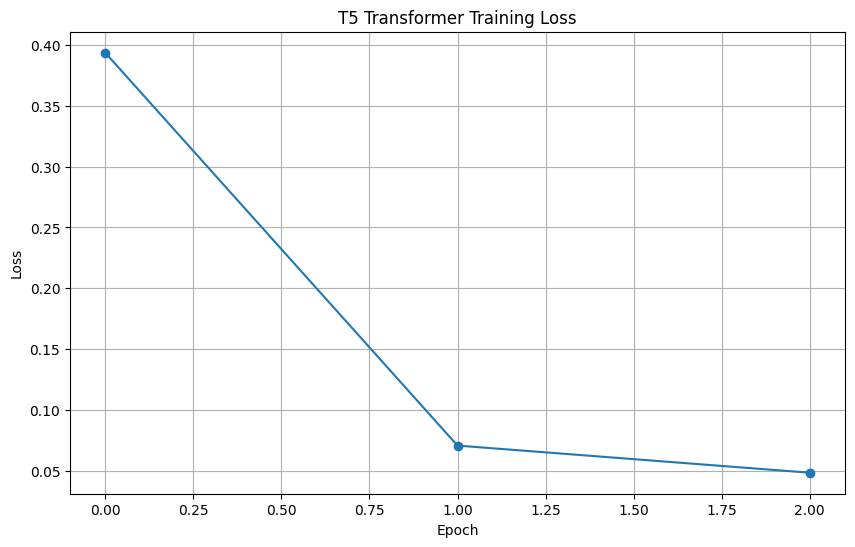

In [23]:
# ─── T5 Dataset Setup ─────────────────────────────────────────────────────
class GrammarDataset(Dataset):
    def __init__(self, source_texts, target_texts, tokenizer, max_len=64):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source = "fix grammar: " + self.source_texts[idx]
        target = self.target_texts[idx]

        source_enc = self.tokenizer(source, truncation=True, padding='max_length',
                                   max_length=self.max_len, return_tensors='pt')
        target_enc = self.tokenizer(target, truncation=True, padding='max_length',
                                    max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': source_enc['input_ids'].squeeze(),
            'attention_mask': source_enc['attention_mask'].squeeze(),
            'labels': target_enc['input_ids'].squeeze()
        }

# Initialize tokenizer and set device
print("Setting up T5 Transformer...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Use the same train-test split as the previous models
# Instead of creating a new split, use the existing ones
t5_train_texts = train_inputs
t5_train_labels = train_targets_plain  # Use plain targets (without tags)
t5_val_texts = test_inputs
t5_val_labels = test_targets_plain     # Use plain targets (without tags)

# Create datasets and dataloaders
train_dataset = GrammarDataset(t5_train_texts.tolist(), t5_train_labels.tolist(), t5_tokenizer)
val_dataset = GrammarDataset(t5_val_texts.tolist(), t5_val_labels.tolist(), t5_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Load model and optimizer
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
t5_epochs = 3
t5_loss_history = []
start_train_t5 = time.time()

for epoch in range(t5_epochs):
    total_loss = 0
    start = time.time()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    t5_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{t5_epochs} - Loss: {avg_loss:.4f} - Time: {time.time()-start:.1f}s")

train_time_t5 = time.time() - start_train_t5

# ─── Evaluate T5 Model ──────────────────────────────────────────────────
print("Evaluating T5 Transformer...")
model.eval()
bleu_scores_t5 = []
meteor_scores_t5 = []
rouge_l_f1_t5 = []
total_samples = 0

start_infer_t5 = time.time()
with torch.no_grad():
    for i in range(min(100, len(val_dataset))):
        sample = val_dataset[i]
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
        labels = sample['labels'].unsqueeze(0).to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=64)

        prediction = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        target = t5_tokenizer.decode(labels[0], skip_special_tokens=True)

        # Calculate metrics
        pred_tokens = prediction.split()
        target_tokens = target.split()

        bleu_scores_t5.append(sentence_bleu([target_tokens], pred_tokens, smoothing_function=smoothie))
        meteor_scores_t5.append(meteor_score([target_tokens], pred_tokens))
        rouge_l_f1_t5.append(scorer.score(target, prediction)['rougeL'].fmeasure)

        total_samples += 1

avg_infer_speed_t5 = (time.time() - start_infer_t5) / total_samples

# ─── Plot T5 Loss ───────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.plot(t5_loss_history, marker='o')
plt.title('T5 Transformer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

print(f"BLEU Score     : {np.mean(bleu_scores_t5):.4f}")
print(f"ROUGE-L F1     : {np.mean(rouge_l_f1_t5):.4f}")
print(f"METEOR Score   : {np.mean(meteor_scores_t5):.4f}")
print(f"Infer Speed    : {avg_infer_speed_t5:.4f} sec/sample")

In [31]:
# ─── Function to Correct Grammar ────────────────────────────────────────
def correct_grammar(sentence, model_type='t5'):
    if model_type == 't5':
        input_text = "fix grammar: " + sentence
        encoding = t5_tokenizer(input_text, padding='max_length', truncation=True,
                               max_length=64, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=encoding['input_ids'],
                                    attention_mask=encoding['attention_mask'],
                                    max_length=64, num_beams=4)

        return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

    elif model_type == 'lstm':
        # Process input through LSTM without attention
        input_seq, _ = encode_pad([sentence.lower()], src_tokenizer)
        pred_seq = greedy_predict(input_seq[0])
        return " ".join([tgt_tokenizer.index_word.get(idx, '') for idx in pred_seq if idx > 0])

    elif model_type == 'lstm_attn':
        # Process input through LSTM with attention
        input_seq, _ = encode_pad([sentence.lower()], src_tokenizer)
        pred_seq = decode_sequence(input_seq[0])
        return " ".join([tgt_tokenizer.index_word.get(idx, '') for idx in pred_seq if idx > 0])

    else:
        return "Invalid model type. Choose 't5', 'lstm', or 'lstm_attn'."

# ─── Comparison Results Table ────────────────────────────────────────────
print("\n=== MODEL COMPARISON RESULTS ===")
results_df = pd.DataFrame({
    'Model': ['LSTM', 'LSTM + Attn', 'T5 Transformer'],
    'BLEU': [
        f"{np.mean(bleu_scores):.4f}",
        f"{np.mean(bleu_scores_attn):.4f}",
        f"{np.mean(bleu_scores_t5):.4f}"
    ],
    'METEOR': [
        f"{np.mean(meteor_scores):.4f}",
        f"{np.mean(meteor_scores_attn):.4f}",
        f"{np.mean(meteor_scores_t5):.4f}"
    ],
    'ROUGE-L': [
        f"{np.mean(rouge_l_f1):.4f}",
        f"{np.mean(rouge_l_f1_attn):.4f}",
        f"{np.mean(rouge_l_f1_t5):.4f}"
    ],
    'Train Time (s)': [
        f"{train_time:.2f}",
        f"{train_time_attn:.2f}",
        f"{train_time_t5:.2f}"
    ],
    'Inference Time (s/sample)': [
        f"{avg_infer_speed:.4f}",
        f"{avg_infer_speed_attn:.4f}",
        f"{avg_infer_speed_t5:.4f}"
    ]
})

print(results_df.to_string(index=False))


=== MODEL COMPARISON RESULTS ===
         Model   BLEU METEOR ROUGE-L Train Time (s) Inference Time (s/sample)
          LSTM 0.9225 0.9410  0.9457         122.45                    0.1337
   LSTM + Attn 0.8899 0.9088  0.9207         693.55                    0.1962
T5 Transformer 0.8627 0.9555  0.9680         314.60                    0.1385


In [33]:
# Try a few examples with each model
test_sentences = [
    "she dont like ice cream",
    "they was running in the park yesterday",
    "he have many book in his shelf"
]

print("\n=== EXAMPLE CORRECTIONS ===")
for sentence in test_sentences:
    print(f"\nOriginal: {sentence}")
   # print(f"LSTM: {correct_grammar(sentence, 'lstm')}")
   # print(f"LSTM + Attention: {correct_grammar(sentence, 'lstm_attn')}")
    print(f"T5 Transformer: {correct_grammar(sentence, 't5')}")


=== EXAMPLE CORRECTIONS ===

Original: she dont like ice cream
T5 Transformer: She doesn't like ice cream

Original: they was running in the park yesterday
T5 Transformer: They were running in the park yesterday.

Original: he have many book in his shelf
T5 Transformer: He has many books in his shelf



=== MODEL COMPARISON RESULTS ===
         Model   BLEU METEOR ROUGE-L Train Time (s) Inference Time (s/sample)
          LSTM 0.9225 0.9410  0.9457         122.45                    0.1337
   LSTM + Attn 0.8899 0.9088  0.9207         693.55                    0.1962
T5 Transformer 0.8627 0.9555  0.9680         314.60                    0.1385


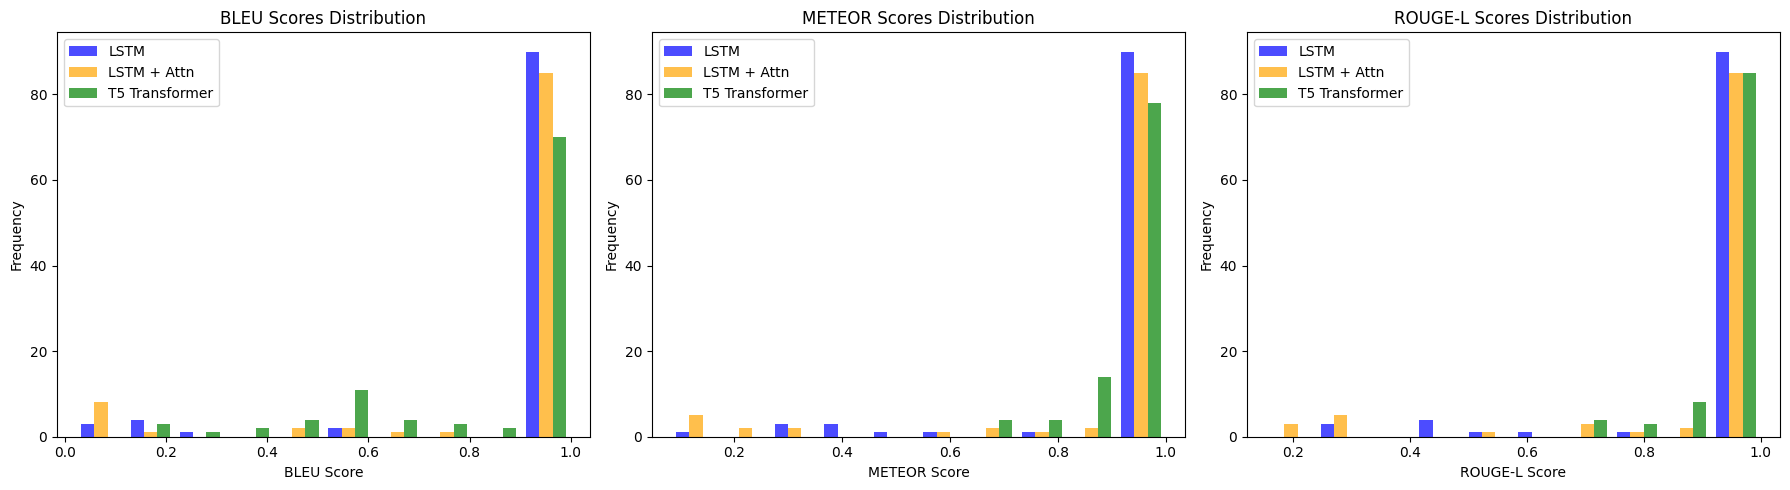

<ipython-input-36-ab1ff5205502>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='BLEU', data=score_df, palette='Set2')
<ipython-input-36-ab1ff5205502>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='METEOR', data=score_df, palette='Set2')
<ipython-input-36-ab1ff5205502>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='ROUGE-L', data=score_df, palette='Set2')


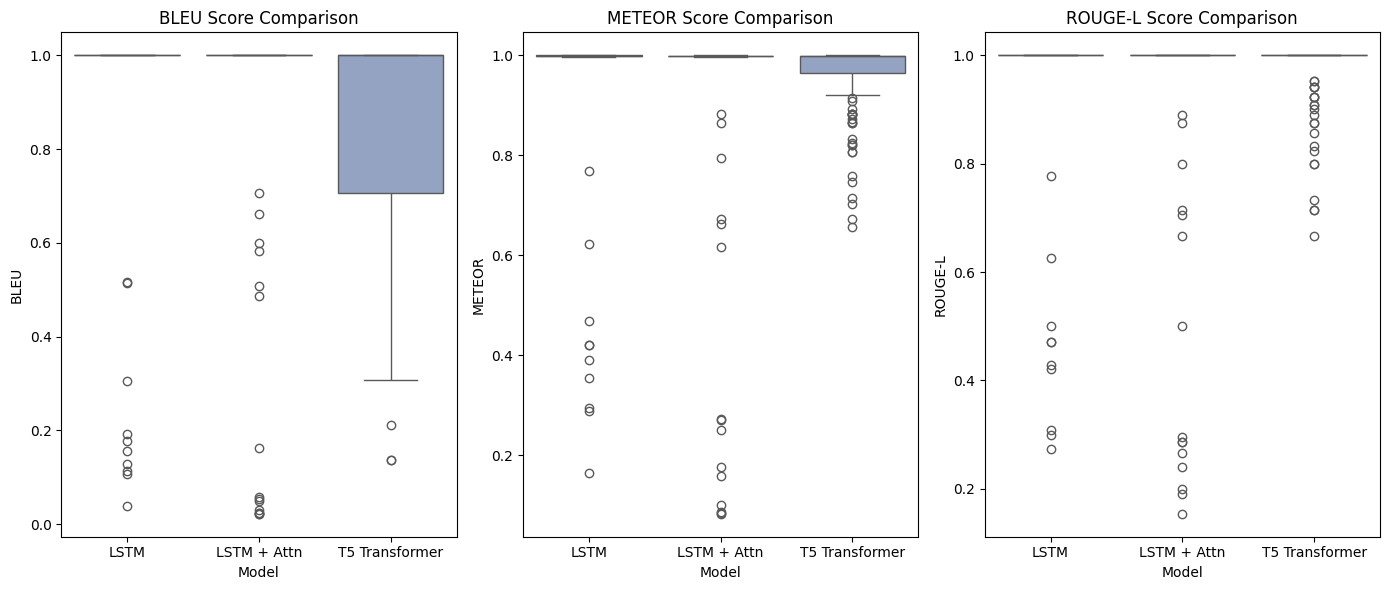

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': ['LSTM', 'LSTM + Attn', 'T5 Transformer'],
    'BLEU': [
        f"{np.mean(bleu_scores):.4f}",
        f"{np.mean(bleu_scores_attn):.4f}",
        f"{np.mean(bleu_scores_t5):.4f}"
    ],
    'METEOR': [
        f"{np.mean(meteor_scores):.4f}",
        f"{np.mean(meteor_scores_attn):.4f}",
        f"{np.mean(meteor_scores_t5):.4f}"
    ],
    'ROUGE-L': [
        f"{np.mean(rouge_l_f1):.4f}",
        f"{np.mean(rouge_l_f1_attn):.4f}",
        f"{np.mean(rouge_l_f1_t5):.4f}"
    ],
    'Train Time (s)': [
        f"{train_time:.2f}",
        f"{train_time_attn:.2f}",
        f"{train_time_t5:.2f}"
    ],
    'Inference Time (s/sample)': [
        f"{avg_infer_speed:.4f}",
        f"{avg_infer_speed_attn:.4f}",
        f"{avg_infer_speed_t5:.4f}"
    ]
})

# Print comparison table
print("\n=== MODEL COMPARISON RESULTS ===")
print(results_df.to_string(index=False))

# Visualization - Histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# BLEU Score Histogram
axs[0].hist([bleu_scores, bleu_scores_attn, bleu_scores_t5], bins=10, label=['LSTM', 'LSTM + Attn', 'T5 Transformer'], color=['blue', 'orange', 'green'], alpha=0.7)
axs[0].set_title('BLEU Scores Distribution')
axs[0].set_xlabel('BLEU Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# METEOR Score Histogram
axs[1].hist([meteor_scores, meteor_scores_attn, meteor_scores_t5], bins=10, label=['LSTM', 'LSTM + Attn', 'T5 Transformer'], color=['blue', 'orange', 'green'], alpha=0.7)
axs[1].set_title('METEOR Scores Distribution')
axs[1].set_xlabel('METEOR Score')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# ROUGE-L Score Histogram
axs[2].hist([rouge_l_f1, rouge_l_f1_attn, rouge_l_f1_t5], bins=10, label=['LSTM', 'LSTM + Attn', 'T5 Transformer'], color=['blue', 'orange', 'green'], alpha=0.7)
axs[2].set_title('ROUGE-L Scores Distribution')
axs[2].set_xlabel('ROUGE-L Score')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()

# Boxplots for Scores Comparison
score_data = {
    'BLEU': bleu_scores + bleu_scores_attn + bleu_scores_t5,
    'METEOR': meteor_scores + meteor_scores_attn + meteor_scores_t5,
    'ROUGE-L': rouge_l_f1 + rouge_l_f1_attn + rouge_l_f1_t5,
    'Model': ['LSTM']*len(bleu_scores) + ['LSTM + Attn']*len(bleu_scores_attn) + ['T5 Transformer']*len(bleu_scores_t5)
}

score_df = pd.DataFrame(score_data)

plt.figure(figsize=(14, 6))

# BLEU Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(x='Model', y='BLEU', data=score_df, palette='Set2')
plt.title('BLEU Score Comparison')

# METEOR Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(x='Model', y='METEOR', data=score_df, palette='Set2')
plt.title('METEOR Score Comparison')

# ROUGE-L Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(x='Model', y='ROUGE-L', data=score_df, palette='Set2')
plt.title('ROUGE-L Score Comparison')

plt.tight_layout()
plt.show()
